In [17]:
import numpy as np

import getdist.plots as gplot

from scipy.integrate import quad
from scipy.constants import physical_constants
from sympy import *
from sympy.physics.mechanics import init_vprinting
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

init_vprinting()

In [2]:
# symbol definitions
phi = symbols('\\phi', real=True)
Mp = symbols('M_{p}')
xi = symbols('\\xi', real=True)
m = symbols('m', real=True, positive=True)

# reduced Planck's mass
rMp = physical_constants['Planck mass'][0] / np.sqrt(8*np.pi)
rMp = 1

# conformal factor
Om = 1 + xi*phi**2/Mp**2

# jordan frame potential - simplest version chaotic model
U = Rational(1,2)*m**2*phi**2 

# einstein frame potential
V = U/Om**2 

dpsidphi = sqrt(1/Om + Rational(3,2)*Mp**2*(diff(Om,phi)/Om)**2)

In [3]:
# potential derivatives
V_p = diff(V,phi)/dpsidphi
V_pp = diff(V_p,phi)/dpsidphi
V_ppp = diff(V_pp,phi)/dpsidphi

In [4]:
# slow-roll parameters symbolic and functional form

# epsilon
eps = Rational(1,2)*Mp**2*V_p**2/V**2
eps_f = lambda phi, xi: 2*(rMp**2 - phi**2*xi)**2/(phi**2*(rMp**2 + 6*phi**2*xi**2 + phi**2*xi))

# eta
eta = Mp**2*V_pp/V
eta_f = lambda phi, xi: 2*(rMp**6 - 6*rMp**4*phi**2*xi - 36*rMp**2*phi**4*xi**3 - 5*rMp**2*phi**4*xi**2 + 12*phi**6*xi**4 + 2*phi**6*xi**3)/(phi**2*(rMp**4 + 12*rMp**2*phi**2*xi**2 + 2*rMp**2*phi**2*xi + 36*phi**4*xi**4 + 12*phi**4*xi**3 + phi**4*xi**2))

# xi_sr
xisr = Mp**4*V_p*V_ppp/V**2

In [5]:
# cosmological parameters

# spectral index of the primordial scalar perturbations
ns = lambda eps, eta: 1 + 2*eta - 6*eps

# running of the spectral index
alp = lambda eps, eta, xisr: -24*eps**2 + 16*eps*eta - 2*xisr

# tensor-to-scalar ration
r = lambda eps: 16*eps

In [6]:
# number of e-foldings integral integrand expression for numerical solution
# will be used to find initial scalar field value
# for N = 50 and N = 60 values 

integrand = dpsidphi/sqrt(2*eps)/Mp

# simplified integrand in pythonic form to perform numerical integration
integrand_f = lambda phi, xi: 0.5*phi*(rMp**2 + 6*phi**2*xi**2 + phi**2*xi)/(rMp**4 - phi**4*xi**2)

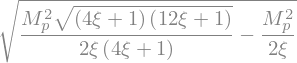

In [7]:
# final value of scalar field
phi_f = solve(eps-1, phi)

# reassign real, positive solution
phi_f = phi_f[3]
display(phi_f)

# function form of final value of scalar field
phi_f_func = lambda xi: rMp*np.sqrt((np.sqrt(48*xi**2 + 16*xi + 1) - 1 - 4*xi)/(8*xi**2 + 2*xi))

In [29]:
# numerical integration setup

# non-minimal coupling constant range
xi_n = np.linspace(-0.002, 0.006, 128)

# step size
dx = 0.5e-2

# tolerance
tol = 1e-1

# 50 e-fold initial field values array initialization
phi_i_50 = []

# 60 e-fold initial field values array initialization
phi_i_60 = []

In [9]:
# integration method : trapezoid
def trapezoid(f, xi, a, b, n):
    dx = (b-a)/n
    res = 0
    for i in range(1,n):
        res += f(a + i*dx, xi)
    res += 0.5*(f(a, xi) + f(b, xi))
    return res*dx

In [33]:
# 50 e-fold integration 

for _xi in tqdm(xi_n):
    N = 0
    i = 0
    integs = []
    while abs(N-50) >= tol:
        integs.append(trapezoid(integrand_f, _xi, phi_f_func(_xi) + i*dx, phi_f_func(_xi) + (i+1)*dx, 32))
        N = sum(integs)
        print(f"{abs(N-50)>=tol} // {N} // {abs(N-50)}" , end='\r')
        i += 1
    phi_i_50.append(phi_f_func(_xi) + (i-1)*dx)

  0%|          | 0/128 [00:00<?, ?it/s]

In [30]:
# 60 e-fold integration 

for _xi in tqdm(xi_n):
    N = 0
    i = 0
    integs = []
    while abs(N-60) >= tol:
        integs.append(trapezoid(integrand_f, _xi, phi_f_func(_xi) + i*dx, phi_f_func(_xi) + (i+1)*dx, 32))
        N = sum(integs)
        print(f"{abs(N-60)>=tol} // {N} // {abs(N-60)}" , end='\r')
        i += 1
    phi_i_60.append(phi_f_func(_xi) + (i-1)*dx)

  0%|          | 0/128 [00:00<?, ?it/s]

In [35]:
# cosmo - param calculation

eta_50 = [eta_f(phi_i_50[i], xi_n[i]) for i in range(len(phi_i_50))]
eps_50 = [eps_f(phi_i_50[i], xi_n[i]) for i in range(len(phi_i_50))]

eta_60 = [eta_f(phi_i_60[i], xi_n[i]) for i in range(len(phi_i_60))]
eps_60 = [eps_f(phi_i_60[i], xi_n[i]) for i in range(len(phi_i_60))]

ns_50 = [ns(eps_50[i], eta_50[i]) for i in range(len(eps_50))]
r_50 = [r(eps_50[i]) for i in range(len(eps_50))]

ns_60 = [ns(eps_60[i], eta_60[i]) for i in range(len(eps_60))]
r_60 = [r(eps_60[i]) for i in range(len(eps_60))]

In [14]:
g = gplot.getSinglePlotter(chain_dir=[r'/Volumes/Newton/planck/2018/COM_CosmoParams_fullGrid_R3.00/base_r/plikHM_TT_lowl_lowE',
                                      r'/Volumes/Newton/planck/2018/COM_CosmoParams_fullGrid_R3.00/base_r/plikHM_TTTEEE_lowl_lowE',
                                      r'/Volumes/Newton/planck/2018/COM_CosmoParams_fullGrid_R3.00/base_r/CamSpecHM_TTTEEE_lowl_lowE_lensing',
                                      r'/Volumes/Newton/planck/2015/COM_CosmoParams_fullGrid_R2.00/base_r/plikHM_TT_lowTEB'])

<Figure size 432x324 with 0 Axes>

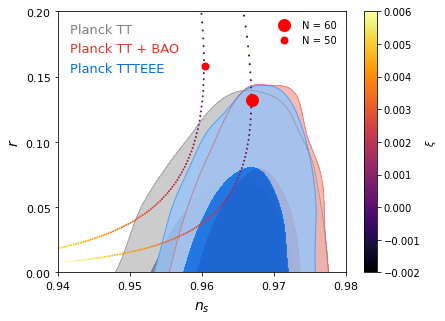

In [62]:
g.settings.legend_frame = False
g.settings.legend_loc = 'best'
g.settings.figure_legend_frame = False

roots = []
roots.append('base_r_plikHM_TT_lowl_lowE')
roots.append('base_r_plikHM_TT_lowl_lowE_post_BAO')
roots.append('base_r_plikHM_TTTEEE_lowl_lowE')
# roots.append('base_r_CamSpecHM_TTTEEE_lowl_lowE_lensing')
# roots.append('base_r_plikHM_TT_lowTEB')
# roots.append('base_r_plikHM_TT_lowTEB_post_BAO')
pairs = [('ns','r')]

g.plots_2d(roots, param_pairs=pairs, legend_labels=[], filled=True, shaded=False)
g.add_line([0.96694214876], [0.132231404959], label=['N = 60'], ls='None', zorder=1, color='red', marker='o', markeredgewidth=7)
g.add_line([0.960396039604], [0.158415841584], label=['N = 50'], ls='None', zorder=1, color='red', marker='o', markeredgewidth=2)

legs = ['Planck TT','Planck TT + BAO','Planck TTTEEE','CamSpec TTTEEE + Lensing','Planck 2015 TT', 'Planck 2015 TT + BAO']
leg1 = g.add_legend(legs[:3], colored_text=True, fontsize=13, legend_loc='upper left', figure=False)
leg2 = g.subplots[0,0].legend(['N = 60', 'N = 50'], loc='upper right', frameon=False)
g.subplots[0,0].add_artist(leg1)

plt.scatter(ns_60, r_60, c=xi_n, s=1, cmap = 'inferno', vmin=xi_n.min(), vmax=xi_n.max())
plt.scatter(ns_50, r_50, c=xi_n, s=1, cmap = 'inferno', vmin=xi_n.min(), vmax=xi_n.max())

plt.colorbar(label = r'$\xi$')
plt.xlim(0.94,0.98)
plt.ylim(0.00,0.20)

g.export('nm.pdf',adir='/Users/sermet/Desktop/work/codes/python/')